tgb - 6/2/2019 - The goal is to make the Figures for the NE Tropical Workshop.

Figure 1:
Make your own movie of  convective heating and moistening for high-performing network
(Jordan)


# 1) Load model and coordinates

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.model_diagnostics import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

# 2) Predict convective heating and moistening on one batch

## 2.1) Define models

In [4]:
!pwd

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [5]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/JNNC.h5'
NN['JNNC'] = load_model(path,custom_objects=dict_lay)
md['JNNC'] = ModelDiagnostics(NN['JNNC'],config_fn,data_fn)
# NNL0.01
path = TRAINDIR+'HDF5_DATA/JNNL.h5'
NN['JNNL'] = load_model(path,custom_objects=dict_lay)
md['JNNL'] = ModelDiagnostics(NN['JNNL'],config_fn,data_fn)

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## 2.2) Convective heating and moistening at level 20 on one batch

In [6]:
NNa = ['JNNC','JNNL']

In [7]:
PHQt = {}; PHQp = {}; PHTt = {}; PHTp = {};

for itime in range(100):
    print('itime=',itime,end="\r")

    for iNN,NNs in enumerate(NNa):

        m = md[NNs] # Reference model diagnostic object
        X, truth = m.valid_gen[itime]
        pred = m.model.predict_on_batch(X)
        PHQt[NNs] = m.reshape_ngeo((truth[:,m.get_output_var_idx('PHQ')]).values)
        PHQp[NNs] = m.reshape_ngeo(pred[:,m.get_output_var_idx('PHQ')])
        PHTt[NNs] = m.reshape_ngeo((truth[:,m.get_output_var_idx('TPHYSTND')]).values)
        PHTp[NNs] = m.reshape_ngeo(pred[:,m.get_output_var_idx('TPHYSTND')])
        # Plot using function below
        fig,ax = ConvQT(PHQt,PHQp,PHTt,PHTp,NNs,fz=30,vmin=-700,vmax=700)
        # Save the figure
        plt.savefig('PNG_DATA/'+'NN'+NNs+'itime'+str(itime))
        plt.close('all')

NameError: name 'ConvQT' is not defined

In [68]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size': fz})
    plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

    ax[0,0].matshow(PHQt[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    ax[0,1].matshow(PHQp[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    ax[1,0].matshow(PHTt[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    img = ax[1,1].matshow(PHTp[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)

    cbaxes = fig.add_axes([0.915, 0.3, 0.03, 0.6]) 
    cbar = fig.colorbar(img, cax=cbaxes)
    cbar.ax.tick_params(labelsize=fz)

    #plt.tight_layout()
    # 0,0
    pos = ax[0,0].get_position()
    pos.x0 = 0.05; pos.x1 = 0.45; pos.y0 = 0.5; pos.y1 = 0.9;
    ax[0,0].set_position(pos)
    ax[0,0].set_ylabel('Heating')
    ax[0,0].title.set_text('Truth (W/m2)')
    ax[0,0].title.set_position([.5, 1.15])
    # 0,1
    pos = ax[0,1].get_position()
    pos.x0 = 0.5; pos.x1 = 0.9; pos.y0 = 0.5; pos.y1 = 0.9;
    ax[0,1].set_position(pos)
    ax[0,1].title.set_text('NN Prediction (W/m2)')
    ax[0,1].title.set_position([.5, 1.15])
    # 1,0
    pos = ax[1,0].get_position()
    pos.x0 = 0.05; pos.x1 = 0.45; pos.y0 = 0.00; pos.y1 = 0.85;
    ax[1,0].set_position(pos)
    # Remove x ticks
    ax[1,0].set_xticklabels([])
    ax[1,0].set_ylabel('Moistening')
    # 1,1
    pos = ax[1,1].get_position()
    pos.x0 = 0.5; pos.x1 = 0.9; pos.y0 = 0.00; pos.y1 = 0.85;
    ax[1,1].set_position(pos)
    ax[1,1].set_xticklabels([])

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
cam_ds.PHQ.isel(time=itime, lev=-1).plot(vmin=-1.9e-7,vmax=1.9e-7,cmap='bwr')

In [122]:
def ConvQT(PHQt,PHQp,PHTt,PHTp,NNs,fz=30,vmin=-700,vmax=700):

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size': fz})
    plt.figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

    fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

    ax[0,0].matshow(PHQt[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    ax[0,1].matshow(PHQp[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    ax[1,0].matshow(PHTt[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)
    img = ax[1,1].matshow(PHTp[NNs][:,:,20],cmap='bwr',vmin=vmin,vmax=vmax)

    cbaxes = fig.add_axes([0.915, 0.3, 0.03, 0.6]) 
    cbar = fig.colorbar(img, cax=cbaxes)
    cbar.ax.tick_params(labelsize=fz)

    #plt.tight_layout()
    # 0,0
    pos = ax[0,0].get_position()
    pos.x0 = 0.05; pos.x1 = 0.45; pos.y0 = 0.5; pos.y1 = 0.9;
    ax[0,0].set_position(pos)
    ax[0,0].set_ylabel('Heating')
    ax[0,0].title.set_text('Truth (W/m2)')
    ax[0,0].title.set_position([.5, 1.15])
    # 0,1
    pos = ax[0,1].get_position()
    pos.x0 = 0.5; pos.x1 = 0.9; pos.y0 = 0.5; pos.y1 = 0.9;
    ax[0,1].set_position(pos)
    ax[0,1].title.set_text('NN Prediction (W/m2)')
    ax[0,1].title.set_position([.5, 1.15])
    # 1,0
    pos = ax[1,0].get_position()
    pos.x0 = 0.05; pos.x1 = 0.45; pos.y0 = 0.00; pos.y1 = 0.85;
    ax[1,0].set_position(pos)
    # Remove x ticks
    ax[1,0].set_xticklabels([])
    ax[1,0].set_ylabel('Moistening')
    # 1,1
    pos = ax[1,1].get_position()
    pos.x0 = 0.5; pos.x1 = 0.9; pos.y0 = 0.00; pos.y1 = 0.85;
    ax[1,1].set_position(pos)
    ax[1,1].set_xticklabels([])
    
    return fig,ax

# 3) Compare mass and enthalpy residuals for both NNL & NNA

In [127]:
NNa = ['JNNC','JNNL']

In [128]:
Nt = 100
res = {}

for iNN,NNs in enumerate(NNa):
    MD = ModelDiagnostics(NN[NNs],config_fn,data_fn)
    MD.compute_res(niter=Nt)
    res[NNs] = MD.res

In [140]:
res[NNs]['mass'].shape

(64, 128, 218)

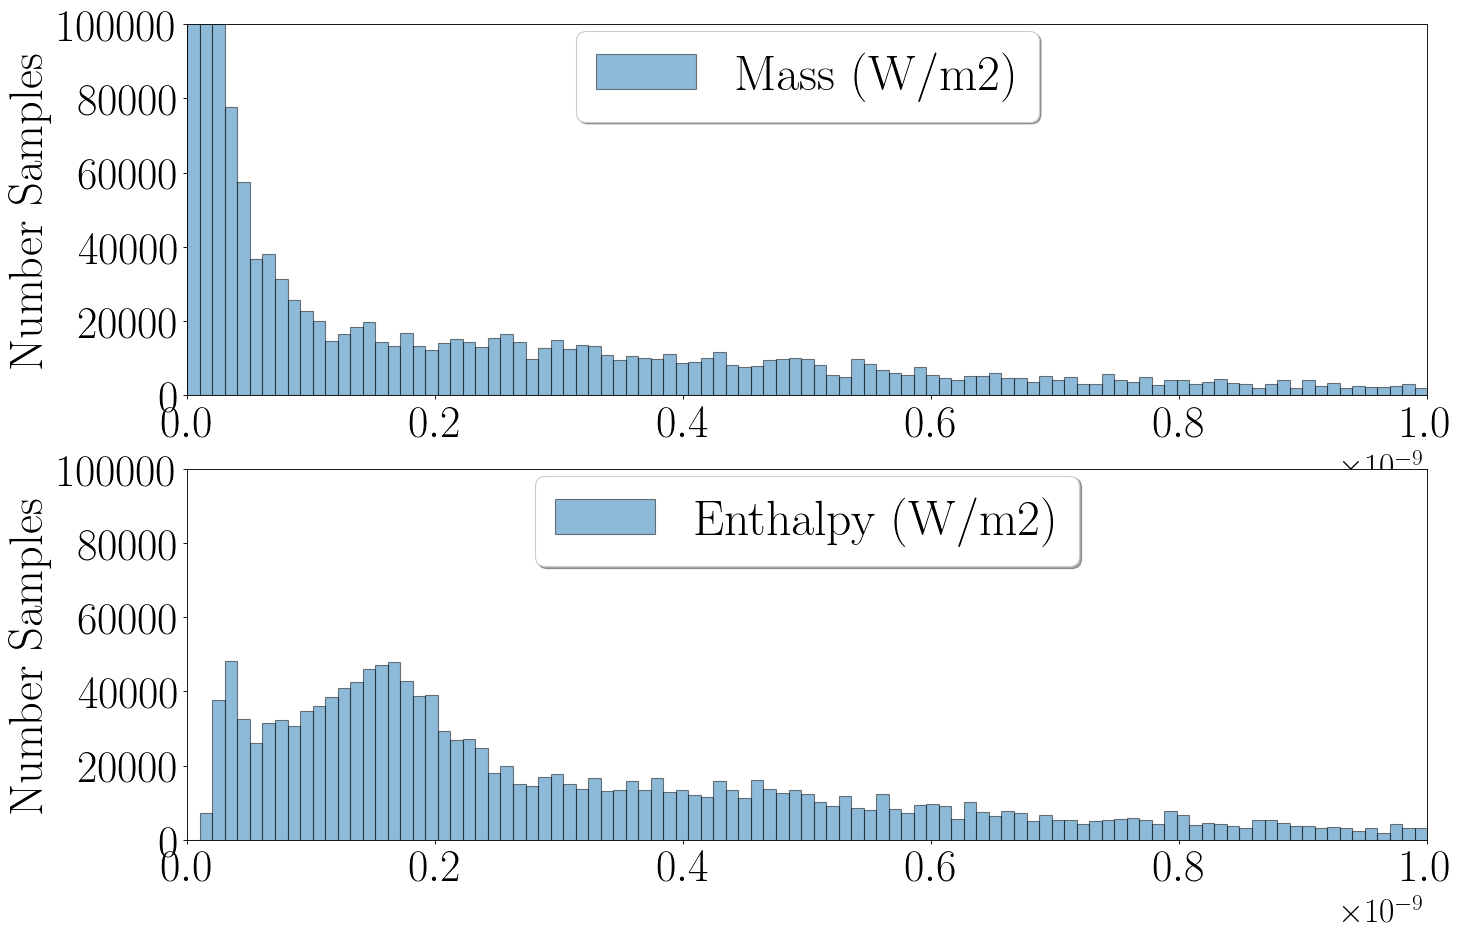

In [169]:
fz = 40
NNs = 'JNNC';
XMAX = 1e-9;

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
bins = np.linspace(0, XMAX, 100)

for index in range (2):
    if index==0: toplot = res[NNs]['mass']; lab = 'Mass (W/m2)';
    elif index==1: toplot = res[NNs]['ent']; lab = 'Enthalpy (W/m2)';
    
    ax = plt.subplot(2,1,index+1)
    ax.hist(toplot.flatten(),bins,alpha=0.5,edgecolor='k',label=lab,density=False)
    plt.ylabel(r'Number Samples', fontsize=fz+2)
    plt.xticks(fontsize=fz); plt.yticks(fontsize=fz)
    plt.ylim((0, 1e5)); plt.xlim((0, XMAX));
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = fz+5); 

# 4) R2 plot for OLR

In [203]:
NNa = ['U_009','JNNL0.01','JNNC','MLRL0']

In [204]:
# NNL0.01
path = TRAINDIR+'HDF5_DATA/JNNL0.01.h5'
NN['JNNL0.01'] = load_model(path,custom_objects=dict_lay)
md['JNNL0.01'] = ModelDiagnostics(NN['JNNL0.01'],config_fn,data_fn)
# NNL0.01
path = TRAINDIR+'HDF5_DATA/MLRL0.h5'
NN['MLRL0'] = load_model(path,custom_objects=dict_lay)
md['MLRL0'] = ModelDiagnostics(NN['MLRL0'],config_fn,data_fn)
# U009
path = TRAINDIR+'HDF5_DATA/U_009.h5'
NN['U_009'] = load_model(path,custom_objects=dict_lay)
md['U_009'] = ModelDiagnostics(NN['U_009'],config_fn,data_fn)

## 4.1) +0K

In [205]:
Nt = 500
statsR2 = {}

data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'

for iNN,NNs in enumerate(NNa):
    MD = ModelDiagnostics(NN[NNs],config_fn,data_fn)
    MD.compute_stats(niter=Nt)
    statsR2[NNs] = MD.stats['r2']

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


## 4.2) +4K

In [206]:
Nt = 500
statsR2_4K = {}

data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc'
for iNN,NNs in enumerate(NNa):
    MD = ModelDiagnostics(NN[NNs],config_fn,data_fn)
    MD.compute_stats(niter=Nt)
    statsR2_4K[NNs] = MD.stats['r2']

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:166: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:172: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


## 4.3) Figure

j= 0 and sst= 0
j= 1 and sst= 4


Text(0, 0.5, '$\\mathrm{R^{2}\\ score}$')

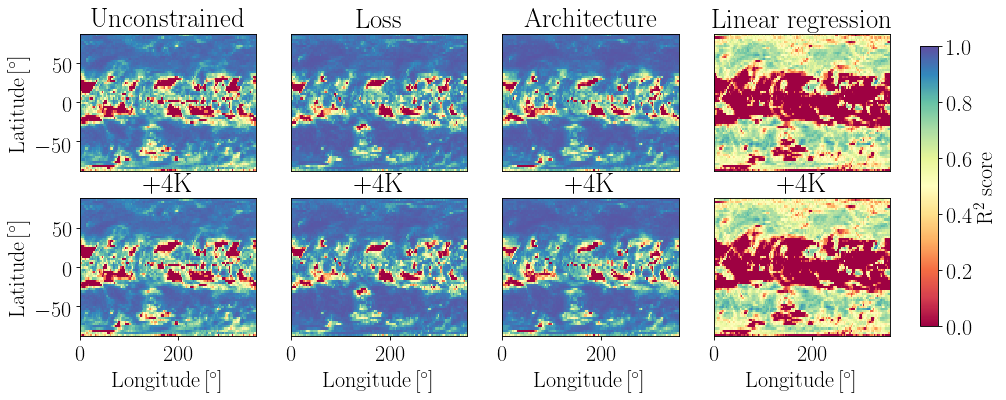

In [207]:
fz = 20

TITarray = ['Unconstrained','Loss','Architecture','Linear regression',
           '+4K','+4K','+4K','+4K'];
VAR = 'FLNT'

SST = [0,4]

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(SST), ncols=len(NNa),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for j,sst in enumerate(SST):
    print('j=',j,'and sst=',sst)
    if sst==0: S = statsR2;
    else: S = statsR2_4K;
    for i,NNs in enumerate(NNa):
        A = S[NNs][:, :, md[NNs].get_output_var_idx(VAR)[0]].T;
        AX = axes.flat[i+j*len(NNa)]
        im = AX.pcolor(lon,lat,A[:,:].T,cmap='Spectral',vmin=0,vmax=1)
        AX.set_title(TITarray[i+j*len(NNa)])
        if j+1==len(SST): AX.set_xlabel(r'$\mathrm{Longitude}\left[^{\circ}\right]$')
        else: AX.get_xaxis().set_ticks([])
        if i==0: AX.set_ylabel(r'$\mathrm{Latitude}\left[^{\circ}\right]$')
        else: AX.get_yaxis().set_ticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, pad = 0.1)
cbar.ax.set_ylabel(r'$\mathrm{R^{2}\ score}$', rotation=90)

In [209]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
fig, axes = plt.subplots(nrows=len(SST), ncols=len(NNa),\
                        num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

# Pressure/lat
for j,sst in enumerate(SST):
    print('j=',j,'and sst=',sst)
    if sst==0: S = statsR2;
    else: S = statsR2_4K;
    for i,NNs in enumerate(NNa):
        A = S[NNs][:, :, md[NNs].get_output_var_idx(VAR)[0]].T;
        AX = axes.flat[i+j*len(NNa)]
        im = AX.pcolor(lon,lat,A[:,:].T,cmap='Spectral',vmin=0,vmax=1)
        AX.set_title(TITarray[i+j*len(NNa)])
        if j+1==len(SST): AX.set_xlabel(r'$\mathrm{Longitude}\left[^{\circ}\right]$')
        else: AX.get_xaxis().set_ticks([])
        if i==0: AX.set_ylabel(r'$\mathrm{Latitude}\left[^{\circ}\right]$')
        else: AX.get_yaxis().set_ticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, pad = 0.1)
cbar.ax.set_ylabel(r'$\mathrm{R^{2}\ score}$', rotation=90)
plt.savefig('PNG_DATA/OLR')
plt.close('all')

j= 0 and sst= 0
j= 1 and sst= 4


# 5) j